In [1]:
%matplotlib inline
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns 
import pandas as pd
import random

sns.set()
sns.set(rc={'figure.figsize':(8,8)})

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Global Params
# Z draws num_repl replications of the mean and std

def getExperimentEnvironment():
    env = {};
    env["num"] = 10000 # points of denisty function
    env["num_repl"] = 1000 #repetitions to get the frequency and statistics of the dist
    env["nq"] = 41 #21
    env["tau"] = 20
    #  performance profiles for part 2
    env["real_params"] = [(0.9, 0.8), (0.8, 0.1), (0.6, 0.4), (0.1, 1),(0.25,0.2)]
    # performance profiles for part 1
    env['real_thetas'] = [0.1, 0.2, 0.5, 0.9,1]
    env['real_lamdas'] = [0.05, 0.07,0.1, 0.2, 1]
  
    #pesimistic prior 03
    env["a"] = 1
    env["b"] = 1
    env["n"] = 1
    env["g"] = 10
    #optimistic prior 07
    env["a2"] = 0.75
    env["b2"] = 0.25
    env["n2"] = 1
    env["g2"] = 1
    # mean prior
    env["a3"] = 0.95
    env["b3"] = 0.05
    env["n3"] = 3
    env["g3"] = 30
    #theta, lambda range of the continuous param values
    env["num_t"] = 100
    env["num_l"] = 100
    
    return env

In [3]:
"""
Calculate the distribution of Z given theta, lambda, and tau
"""  
# the score distribution given the real or updated state 
def true_distribution(theta, lamda, tau, num):
    env = getExperimentEnvironment();

    accuracy = np.random.binomial(n=1, p=theta, size=num)
    rt = np.random.exponential(scale=1/lamda, size=num)
    z = accuracy * (1 - np.minimum(rt, tau) / tau) #responsible for making the function range [0,1]

    return z

In [4]:
"""
Calculate the estimated distribution of Z given the priors and tau
-  A bayesian mechanism wιth conjugage priors over the unknown parameters of true distribution(e.g., E[λ] ~ par_n/par_g)
- The Density of Z depends on the prior parameters (par_a, par_b, par_n, par_g)
"""
def est_distribution(par_a, par_b, par_n, par_g, tau, num):
    #priors
    theta = np.random.beta(a = par_a, b = par_b)
    lamda = np.random.gamma(shape = par_n, scale = 1/par_g)
    z = true_distribution(theta, lamda, tau, num) 

    return z 

In [5]:
"""
1 session (i.e.,sequence) of students's performance
"""
def a_session(theta, lamda, tau, par_a, par_b, par_n, par_g, nq, num_repl):
    result_theta = np.zeros(nq)
    result_lamda = np.zeros(nq)
    result_a = np.zeros(nq)
    result_b = np.zeros(nq)
    result_n = np.zeros(nq)
    result_g = np.zeros(nq)
   
    result_theta[0] += par_a / (par_a + par_b)
    result_lamda[0] += par_n / par_g

    result_a[0] += par_a
    result_b[0] += par_b
    result_n[0] += par_n
    result_g[0] += par_g
    #for repl in range(num_repl):
    loc_a, loc_b, loc_n, loc_g = par_a, par_b, par_n, par_g
        
    for i in range(nq-1):
        correct = np.random.binomial(n=1, p = theta)
        rt = np.random.exponential(scale = 1/lamda)

        loc_a += correct
        loc_b += (1 - correct)
        loc_n += 1
        loc_g += rt
    
        result_theta[i] += loc_a / (loc_a + loc_b)
        result_lamda[i] += loc_n / loc_g            
        result_a[i] += loc_a
        result_b[i] += loc_b
        result_n[i] += loc_n
        result_g[i] += loc_g
        
    # result_theta /= num_repl    
    # result_lamda /= num_repl 
    # result_a /= num_repl 
    # result_b /= num_repl 
    # result_n /= num_repl 
    # result_g /= num_repl 
    
    return result_theta, result_lamda, result_a, result_b, result_n, result_g

In [6]:
def get_realizations(
    real_theta, real_lambda, tau, num, par_a, par_b, par_n, par_g, nq, num_repl
):
    score = np.zeros((num_repl, nq, num))
    est_theta, est_lamda = np.zeros(nq),np.zeros(nq)
    
    for repl in range(num_repl):
        res_theta, res_lamda, est_a, est_b, est_n, est_g = a_session(
            real_theta, real_lambda, tau, par_a, par_b, par_n, par_g, nq
        )

        for i in range(nq):
            score[repl, i, :] = est_distribution(
                est_a[i], est_b[i], est_n[i], est_g[i], tau, num
            )
            est_theta[i] += res_theta[i]
            est_lamda[i] += res_lamda[i]
    est_theta /= num_repl
    est_lamda /= num_repl

    return score, est_theta, est_lamda


#### Numerical Experiments: Part One

Text(0, 0.5, 'E[Z]')

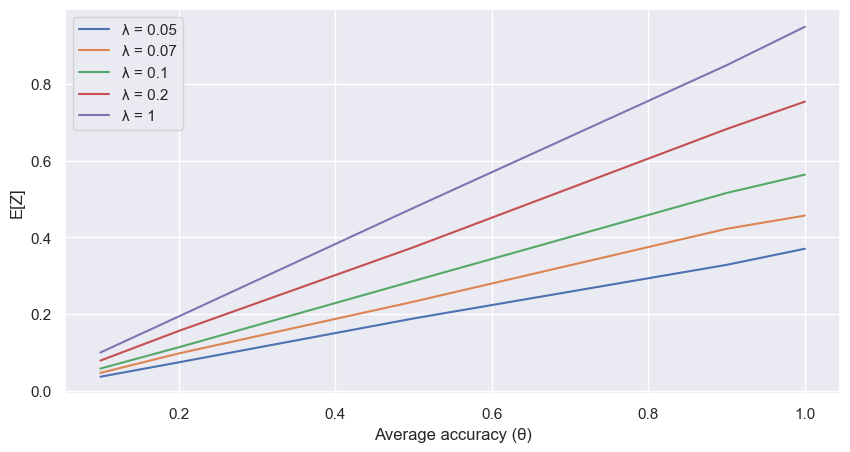

In [7]:
env = getExperimentEnvironment()

numl = len(env['real_lamdas'])
numt = len(env['real_thetas'])
z = np.zeros(numt)

plt.figure(figsize=(10,5))

for j in range(numl):
    for i in range(numt):
        arr = true_distribution(env['real_thetas'][i], env['real_lamdas'][j], env['tau'], env['num']) 
        z[i] = np.mean(arr)
    
    plt.plot(env['real_thetas'], z, label = 'λ = ' + str(env['real_lamdas'][j]))

plt.legend()
plt.xlabel("Average accuracy (θ)")
plt.ylabel("E[Z]")

Text(0, 0.5, 'E[Z]')

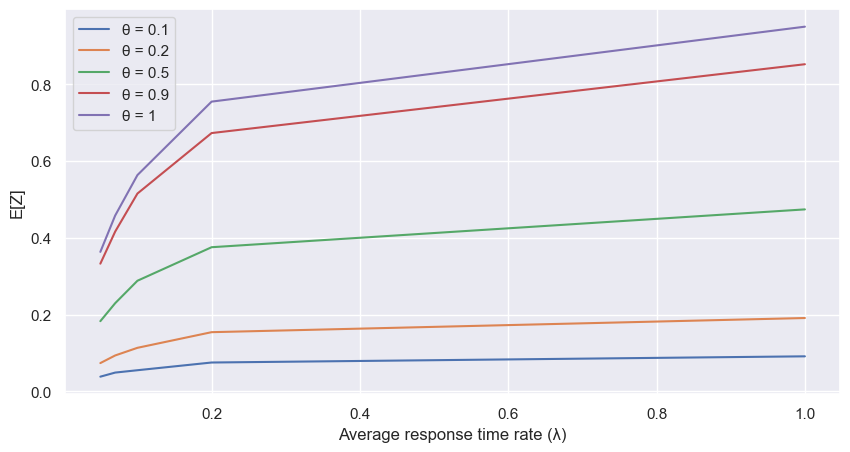

In [8]:
env = getExperimentEnvironment()

numl = len(env['real_lamdas'])
numt = len(env['real_thetas'])
z = np.zeros(numt)


plt.figure(figsize=(10,5))


for i in range(numt):
    for j in range(numl):
        arr = true_distribution(env['real_thetas'][i], env['real_lamdas'][j], env['tau'], env['num']) 
        z[j] = np.mean(arr)
    
    plt.plot(env['real_lamdas'], z, label = 'θ = ' + str(env['real_thetas'][i]))

plt.legend(loc= 'upper left')
plt.xlabel("Average response time rate (λ)")
plt.ylabel("E[Z]")

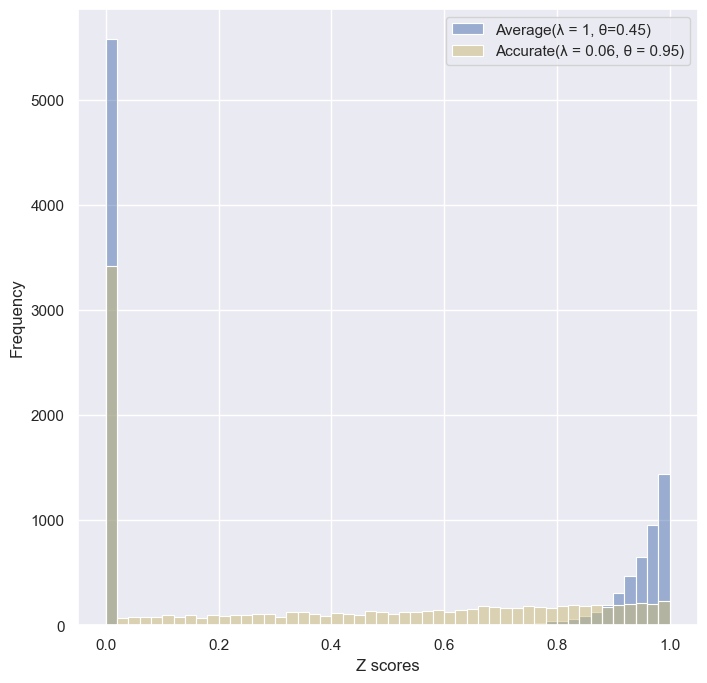

In [9]:
prof_one = true_distribution(0.45,1,20,10000)
prof_two = true_distribution(0.95,0.06,20,10000)
profs = [prof_one,prof_two]
colors = ['b','y']
i = 0 
fig = plt.subplots(1,1)
sns.set(rc={'figure.figsize':(5,5)}, color_codes=True)

for prof in profs:
    ax = sns.histplot(prof, bins=50, color = colors[i], legend = True, alpha=0.5)
    i+=1
    
    
plt.ylabel('Frequency')
plt.xlabel('Z scores')
plt.legend(['Average(λ = 1, θ=0.45)','Accurate(λ = 0.06, θ = 0.95)'])

#### Experiments Part Two
 - Run the simulations and store them for later use
 - Run with optimistic and pessimistic priors
 - Calculate and store the true data and the statistics


In [10]:
'''
# Running this takes a lot computational power
env = getExperimentEnvironment();

prior03 = (env["a"], env["b"], env["n"], env["g"])
prior07 = (env["a2"], env["b2"], env["n2"], env["g2"])

priors = np.array([prior03, prior07])

bama_scores = np.zeros((
    3,
    len(env["real_params"]),
    env["num_repl"],
    env["nq"],
    env["num"]
))
est_theta = np.zeros((3,len(env["real_params"]), env["nq"]))
est_lamda = np.zeros((3,len(env["real_params"]), env["nq"]))

for j in range(len(env["real_params"])):
    real_theta = env["real_params"][j][0]
    real_lambda = env["real_params"][j][1]

    dummy = get_realizations(
        real_theta,
        real_lambda,
        env["tau"],
        env["num"],
        env["a"],
        env["b"],
        env["n"],
        env["g"],
        env["nq"],
        env["num_repl"]
    )
    bama_scores[0][j] = dummy[0]
    est_theta[0][j] = dummy[1]
    est_lamda[0][j] = dummy[2]

    # OPTIMISTIC PRIOR

    dummy_optimistic = get_realizations(
        real_theta,
        real_lambda,
        env["tau"],
        env["num"],
        env["a2"],
        env["b2"],
        env["n2"],
        env["g2"],
        env["nq"],
        env["num_repl"]
    )
    bama_scores[1][j] = dummy_optimistic[0]
    est_theta[1][j] = dummy_optimistic[1]
    est_lamda[1][j] = dummy_optimistic[2]

    dummy_mean = get_realizations(
        real_theta,
        real_lambda,
        env["tau"],
        env["num"],
        env["a3"],
        env["b3"],
        env["n3"],
        env["g3"],
        env["nq"],
        env["num_repl"]
    )
    bama_scores[2][j] = dummy_mean[0]
    est_theta[2][j] = dummy_mean[1]
    est_lamda[2][j] = dummy_mean[2]

    
# Store the simulations for later usage
np.save("bama_scores", bama_scores)
np.save("est_theta", est_theta)
np.save("est_lamda", est_lamda)

# TRUE DATA

true_scores = np.zeros((
        len(env["real_params"]),
        env["num"]
        ))
for i in range(rpt):
    for j in range(len(env["real_params"])):
        real_theta = env["real_params"][j][0]
        real_lambda = env["real_params"][j][1]
        true_scores[j] += true_distribution(real_theta,real_lambda,env["tau"], env["num"])
true_scores /= rpt

#Store the true distributions for later usage
np.save("./true_scores", true_scores)


# STATISTICS
students_mean_stats03 = [[] for j in range(len(env["real_params"]))];
students_mean_stats07 = [[] for j in range(len(env["real_params"]))];
students_mean_stats05 = [[] for j in range(len(env["real_params"]))];

for j in range(len(env["real_params"])):
    # 0. z belong to(m,n,N)
    score = scores03[j];
    
    # 1.array (n,N): dist of Z as an avg distribution of Z
    # Level of averaging: m 
    mean_of_dist3 = score.mean(axis=0)
    # print(np.asarray(mean_of_dist).shape) # (21,1000)

    # 2.array (m,n): sample mean, sample std arrays (1000, 21)
    # Level of averaging: N
    stdSamples3 = score.std(axis=2)#
    meanSamples3 = score.mean(axis=2)
    
    # 3.array (n): mean of sample mean, mean of sample std, standard error of the sample mean
    # Level of averaging: N,m (i.e., takes 2. and provides an avg on m)
    mean_of_mean = meanSamples3.mean(axis=0) #nq
    mean_of_std = stdSamples3.mean(axis=0) #nq
    sem = np.divide(meanSamples3.std(axis = 0),np.sqrt(env["num_repl"])) #nq
    
    students_mean_stats03[j] = (mean_of_mean, mean_of_std, sem, meanSamples3,mean_of_dist3, est_theta03[j],est_lamda03[j])
    
for j in range(len(env["real_params"])):
    score = scores07[j];

    stdSamples7 = score.std(axis=2)#(1000, 21)
    meanSamples7 = score.mean(axis=2)
    
    mean_of_mean = meanSamples7.mean(axis=0) #nq
    mean_of_std = stdSamples7.mean(axis=0) #nq
    sem = np.divide(meanSamples7.std(axis = 0),np.sqrt(env["num_repl"])) #nq
    mean_of_dist7 = score.mean(axis=0)#(21, 10000)

    students_mean_stats07[j] = (mean_of_mean, mean_of_std, sem, meanSamples7,mean_of_dist7, est_theta07[j],est_lamda07[j])

for j in range(len(env["real_params"])):
    score = scores05[j];

    stdSamples5 = score.std(axis=2)
    meanSamples5 = score.mean(axis=2)
    
    mean_of_mean = meanSamples5.mean(axis=0) #nq
    mean_of_std = stdSamples5.mean(axis=0) #nq
    sem = np.divide(meanSamples5.std(axis = 0),np.sqrt(env["num_repl"])) #nq
    mean_of_dist5 = score.mean(axis=0)#(21, 10000)

    students_mean_stats05[j] = (mean_of_mean, mean_of_std, sem, meanSamples5,mean_of_dist5, est_theta05[j],est_lamda05[j])

np.save('students_mean_stats03',students_mean_stats03)
np.save('students_mean_stats07',students_mean_stats07)
np.save('students_mean_stats05',students_mean_stats05)


'''

'\n# Running this takes a lot computational power\nenv = getExperimentEnvironment();\n\nprior03 = (env["a"], env["b"], env["n"], env["g"])\nprior07 = (env["a2"], env["b2"], env["n2"], env["g2"])\n\npriors = np.array([prior03, prior07])\n\nbama_scores = np.zeros((\n    3,\n    len(env["real_params"]),\n    env["num_repl"],\n    env["nq"],\n    env["num"]\n))\nest_theta = np.zeros((3,len(env["real_params"]), env["nq"]))\nest_lamda = np.zeros((3,len(env["real_params"]), env["nq"]))\n\nfor j in range(len(env["real_params"])):\n    real_theta = env["real_params"][j][0]\n    real_lambda = env["real_params"][j][1]\n\n    dummy = get_realizations(\n        real_theta,\n        real_lambda,\n        env["tau"],\n        env["num"],\n        env["a"],\n        env["b"],\n        env["n"],\n        env["g"],\n        env["nq"],\n        env["num_repl"]\n    )\n    bama_scores[0][j] = dummy[0]\n    est_theta[0][j] = dummy[1]\n    est_lamda[0][j] = dummy[2]\n\n    # OPTIMISTIC PRIOR\n\n    dummy_op

In [11]:
# Load the data you run from the above commented experiment
# It takes some time
true_scores = np.load("./data_bama_paper1/true_scores.npy")
bama_scores = np.load("./data_bama_paper1/bama_scores.npy")
est_theta = np.load("./data_bama_paper1/est_theta.npy")
est_lamda = np.load("./data_bama_paper1/est_lamda.npy")
# scores for pessimistic, optimistic, mean
scores03 = bama_scores[0]
scores07 = bama_scores[1]
scores05 = bama_scores[2]
# est theta for pessimistic, optimistic, mean
est_theta03 = est_theta[0]
est_theta07 = est_theta[1]
est_theta05 = est_theta[2]
# est lamda for pessimistic, optimistic, mean
est_lamda03 = est_lamda[0]
est_lamda07 = est_lamda[1]
est_lamda05 = est_lamda[2]

students_mean_stats03 = np.load('./data_bama_paper1/students_mean_stats03.npy',allow_pickle=True)
students_mean_stats07 = np.load('./data_bama_paper1/students_mean_stats07.npy',allow_pickle=True)
students_mean_stats05 = np.load('./data_bama_paper1/students_mean_stats05.npy',allow_pickle=True)


In [12]:
env = getExperimentEnvironment()
students_true_scores = [[] for j in range(len(env["real_params"]))]

for j in range(len(env["real_params"])):
    true_score = true_scores[j]
    true_mean = true_score.mean()
    true_std = true_score.std()
    students_true_scores[j] = (true_mean, true_std)
print("True (Mean and STD): \n\n" + str(np.round(students_true_scores, 3)))


True (Mean and STD): 

[[0.844 0.029]
 [0.454 0.038]
 [0.526 0.044]
 [0.095 0.029]
 [0.188 0.035]]


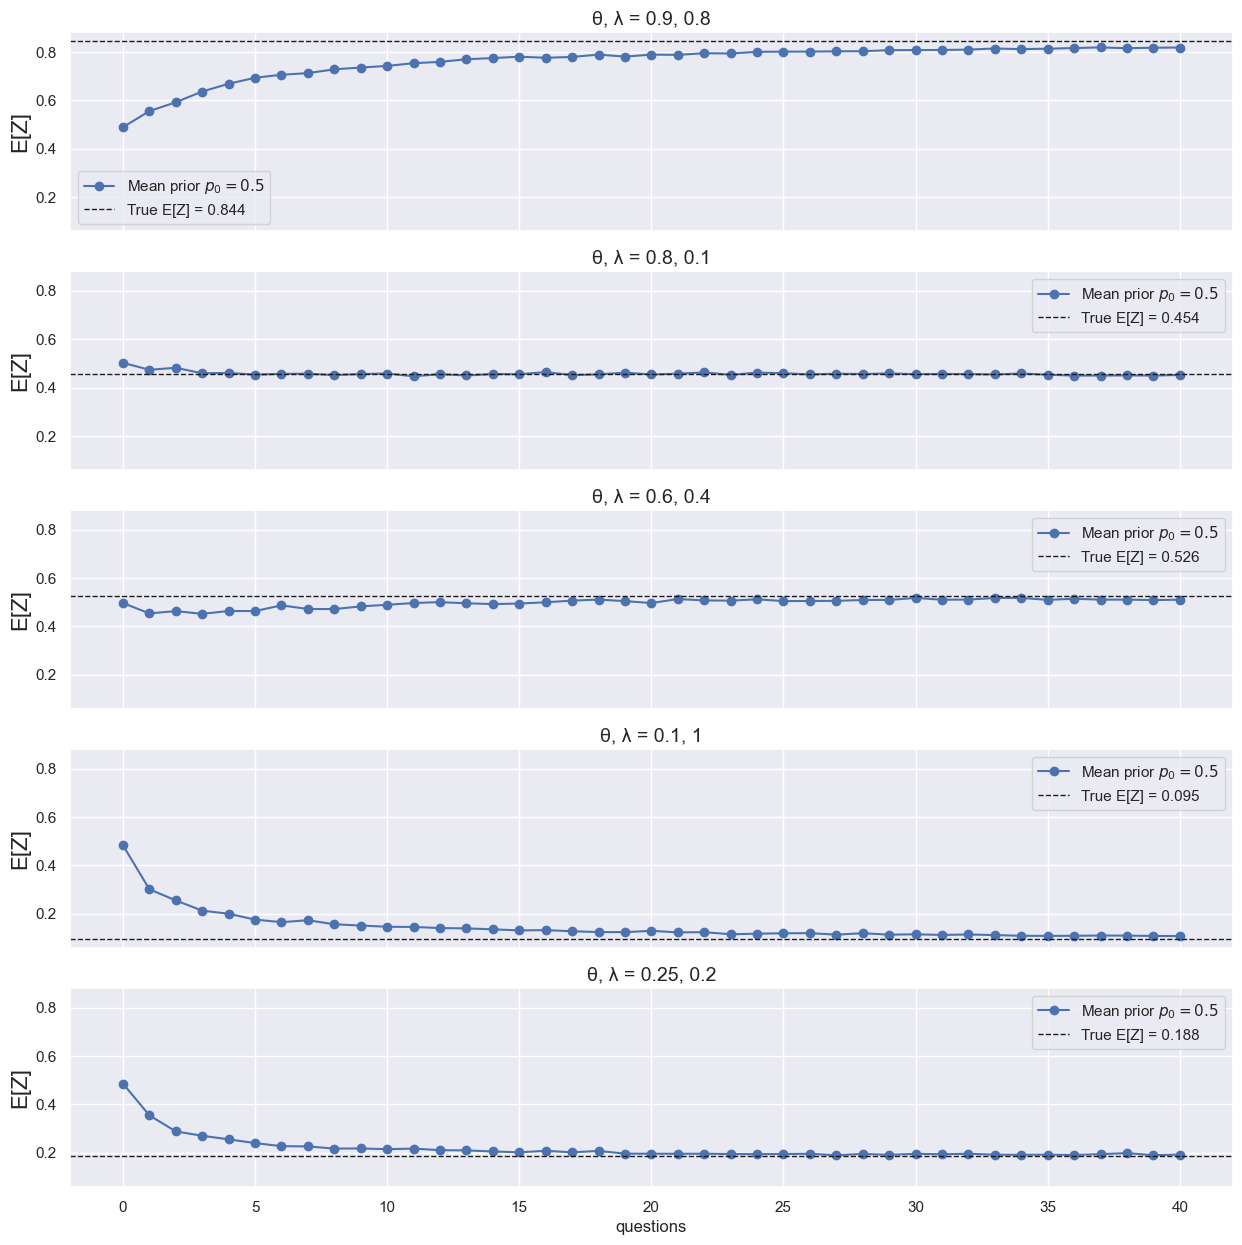

In [13]:
#Plot Prior 05
env = getExperimentEnvironment()
real_m = np.zeros(len(env["real_params"]))

fig, axs = plt.subplots(5,1, figsize = (15,15), sharey=True)
# fig.subplots_adjust(wspace = .05)

for j in range(len(env["real_params"])):
    real_theta = env["real_params"][j][0]
    real_lambda = env["real_params"][j][1]
    result_z = students_mean_stats05[j][0]
    real_m[j] = np.round(students_true_scores[j][0],3)

    ax = axs[j]
    ax.plot(result_z, marker = 'o',label = 'Mean prior' + " " + r'$p_0 = 0.5$') 
    ax.axhline(
        real_m[j],
        color='k',
        linestyle='dashed',
        linewidth=1,
        label = 'True E[Z] = ' + str(real_m[j])
    )
    ax.set_title('θ, λ = ' + str(real_theta) + (', ') + str(round(real_lambda,3)), fontsize=14)
    ax.yaxis.set_label_text('E[Z]', ha = 'center', fontsize=16)
    ax.xaxis.set_label_text('questions', ha = 'center')
    ax.label_outer()
    ax.legend()
plt.show()

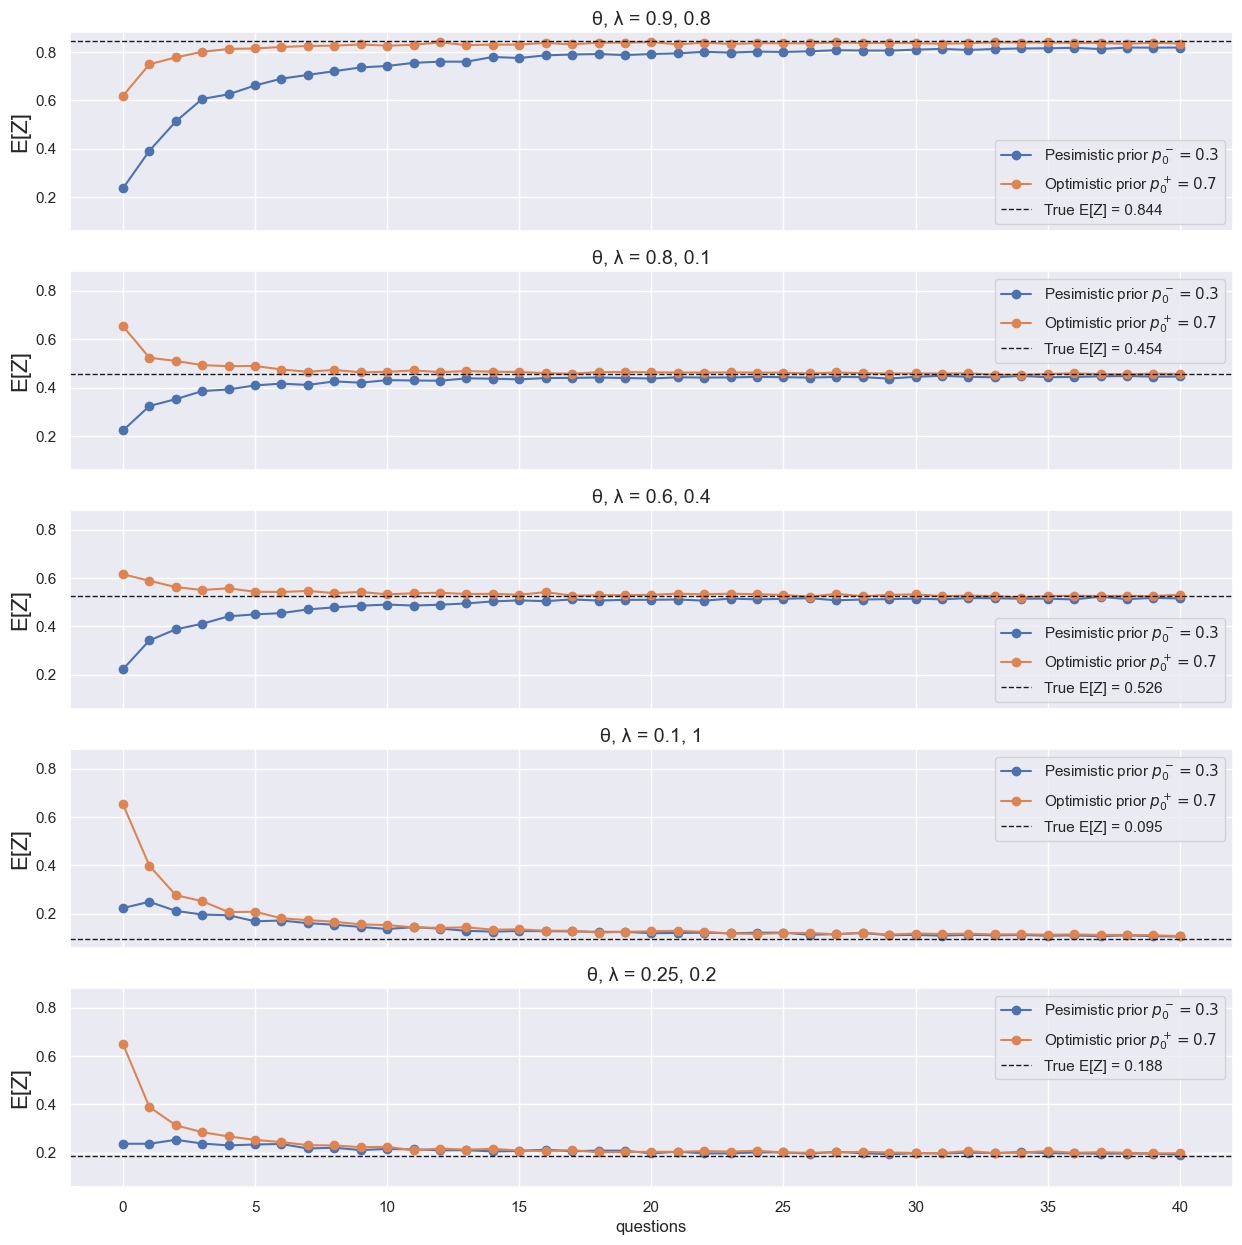

In [14]:
#Plot sensitivity analysis
env = getExperimentEnvironment()
real_m = np.zeros(len(env["real_params"]))

fig, axs = plt.subplots(5,1, figsize = (15,15), sharey=True)

for j in range(len(env["real_params"])):
    real_theta = env["real_params"][j][0]
    real_lambda = env["real_params"][j][1]
    result_z = students_mean_stats03[j][0]
    result_z2 = students_mean_stats07[j][0] 
    real_m[j] = np.round(students_true_scores[j][0],3)

    ax = axs[j]
    ax.plot(result_z, marker = 'o',label = 'Pesimistic prior' + " " + r'$p_0^- = 0.3$')
    ax.plot(result_z2,marker = 'o',label = 'Optimistic prior' + " " + r'$p_0^+ = 0.7$') 
    ax.axhline(
        real_m[j],
        color='k',
        linestyle='dashed',
        linewidth=1,
        label = 'True E[Z] = ' + str(real_m[j])
    )
    
    ax.set_title('θ, λ = ' + str(real_theta) + (', ') + str(round(real_lambda,3)), fontsize=14)
    ax.yaxis.set_label_text('E[Z]', ha = 'center', fontsize=16)
    ax.xaxis.set_label_text('questions', ha = 'center')
    ax.label_outer()
    ax.legend()
plt.show()

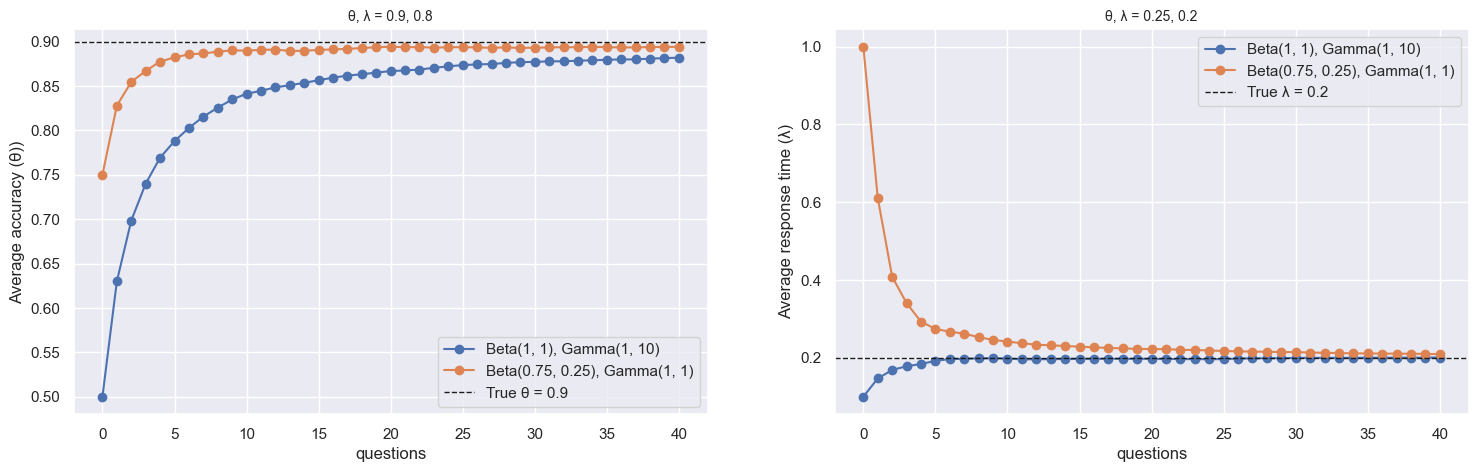

In [15]:
#Plot for the estimated parameters with the two priors
env = getExperimentEnvironment()
# est theta for theta = 0.9, lamda = 0.8
est_theta_array03 = students_mean_stats03[0][5]
est_theta_array07 = students_mean_stats07[0][5]
# est lamda for lamda = 0.2, theta = 0.25
est_lamda_array03 = students_mean_stats03[4][6]
est_lamda_array07 = students_mean_stats07[4][6]


fig, (ax1, ax2) = plt.subplots(1,2, figsize = (18,5))
est_theta_array03 = students_mean_stats03[0][5]
est_theta_array07 = students_mean_stats07[0][5]

ax1.plot(est_theta_array03, marker = 'o',label = 'Beta(' + str(env['a']) + ', ' + str(env['b']) + '), Gamma(' + str(env['n']) + ', ' + str(env['g']) + ')')
x=np.linspace(0,env["nq"]-1,env["nq"])

ax1.plot(est_theta_array07,marker = 'o',label = 'Beta(' + str(env['a2']) + ', ' + str(env['b2']) + '), Gamma(' + str(env['n2']) + ', ' + str(env['g2']) + ')')
    
ax1.axhline(
    env["real_params"][0][0], #0.9,
    color='k',
    linestyle='dashed',
    linewidth=1,
    label = 'True θ = ' + str(env["real_params"][0][0])
)
ax1.yaxis.set_label_text('Average accuracy (θ))', ha = 'center', fontsize=12)
ax1.xaxis.set_label_text('questions', ha = 'center')
ax1.set_title('θ, λ = ' + str(env["real_params"][0][0]) + (', ') + str(env["real_params"][0][1]), fontsize=10)
ax1.legend()

ax2.plot(est_lamda_array03, marker = 'o',label = 'Beta(' + str(env['a']) + ', ' + str(env['b']) + '), Gamma(' + str(env['n']) + ', ' + str(env['g']) + ')')
x=np.linspace(0,env["nq"]-1,env["nq"])

ax2.plot(est_lamda_array07,marker = 'o',label = 'Beta(' + str(env['a2']) + ', ' + str(env['b2']) + '), Gamma(' + str(env['n2']) + ', ' + str(env['g2']) + ')')
    
ax2.axhline(
    env["real_params"][4][1], #0.2
    color='k',
    linestyle='dashed',
    linewidth=1,
    label = 'True λ = ' + str(env["real_params"][4][1])
)

ax2.set_title('θ, λ = ' + str(env["real_params"][4][0]) + (', ') + str(env["real_params"][4][1]), fontsize=10)
ax2.yaxis.set_label_text('Average response time (λ)', ha = 'center', fontsize=12)
ax2.xaxis.set_label_text('questions', ha = 'center')
plt.legend()
plt.show()

#### Experiments Part Three

Text(0.04, 0.5, 'Density Z')

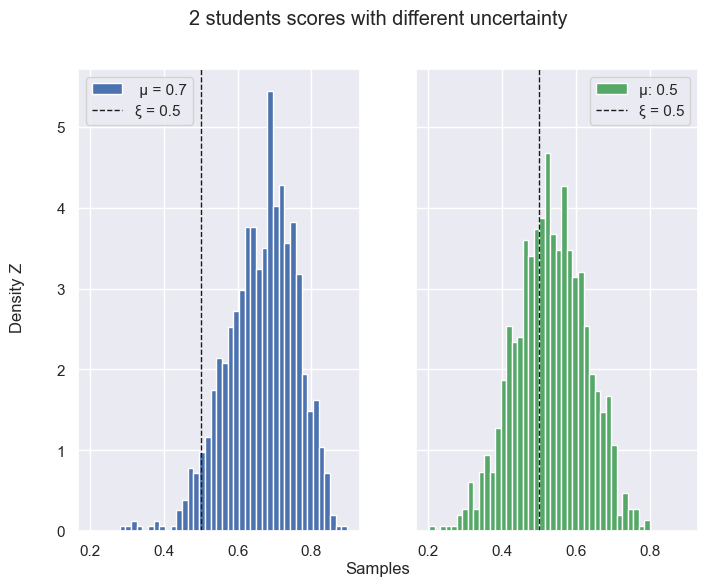

In [16]:
# The plot with different variances

"""constants"""
samples = 1000
xi = 0.5 #mastery threshold
z1 = np.zeros(samples,)
z2 = np.zeros(samples,)

"""function"""
for j in range (samples):
    z1[j] = np.mean(est_distribution(15,5,10,20, 20, 10000)) #θest=0.75, λεστ = 2
    z2[j] = np.mean(est_distribution(12,8,10,20, 20, 10000)) #θest=0.6, λεστ = 2

"""PLOTS"""
fig, ((ax1, ax2)) = plt.subplots(1, 2, sharex = True, sharey = True, figsize = (8,6))
fig.suptitle("2 students scores with different uncertainty")
ax1.hist(z1, color = 'b', bins = 40, density=True, label = ' μ = ' + str(round(np.mean(z1),1)))
ax1.axvline(xi,color='k', linestyle='dashed', linewidth=1, label = 'ξ = ' + str(xi))


ax2.hist(z2, color = 'g', bins = 40, density=True, label = 'μ: ' + str(round(np.mean(z2),1)))
ax2.axvline(xi,color='k', linestyle='dashed', linewidth=1, label = 'ξ = ' + str(xi))
ax1.label_outer()
ax1.legend() 
ax2.label_outer()
ax2.legend()

fig.text(0.5, 0.04, 'Samples', ha='center')
fig.text(0.04, 0.5, 'Density Z', va='center', rotation='vertical')

#### Part four: Rules to distinguish different profiles

In [18]:
def isocurves_mean(num_t, num_l, num, tau):
    results = np.zeros((num_t, num_l), dtype=float)

    for theta in range(num_t):
        for lamda in range(num_l):
            results[theta, lamda] = np.ceil(10 * np.mean(true_distribution((theta+1)/num_t, (lamda+1)/num_l, tau, num))) / 10
    return results

In [19]:
rpt = 50

env = getExperimentEnvironment()

dataMean = np.zeros((env["num_t"], env["num_l"]), dtype=float)
for i in range(rpt):
    dataMean += isocurves_mean(
        env["num_t"],
        env["num_l"],
        env["num"],
        env["tau"]
    )

dataMean /= rpt


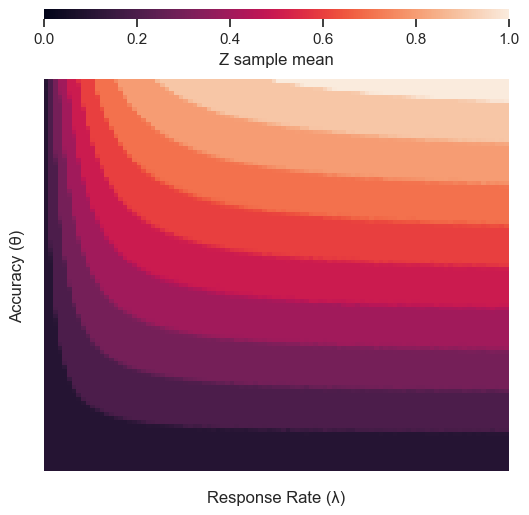

In [20]:
grid_kws = {"height_ratios": (0.05, 2), "hspace": 0.3}
fig, (cbar_ax, ax) = plt.subplots(2, gridspec_kw=grid_kws, figsize=(6,6))

yticks = np.linspace(0,1,10)
xticks = np.linspace(0,1,10)
#r'\textbf{Z score}'
ax = sns.heatmap(
    dataMean,
    cbar_kws={'label': 'Z sample mean',"orientation": "horizontal"}, ax=ax, cbar_ax=cbar_ax, vmin = 0,vmax = 1, xticklabels=np.round(xticks,1), yticklabels=np.round(yticks,1))#xticklabels=[0.0]
ax.invert_yaxis()
ax.set_xlabel("Response Rate (λ)") #,fontsize=18
ax.set_ylabel("Accuracy (θ)")
ax.set_yticks(yticks*ax.get_ylim()[1])
ax.set_xticks(xticks*ax.get_xlim()[1])

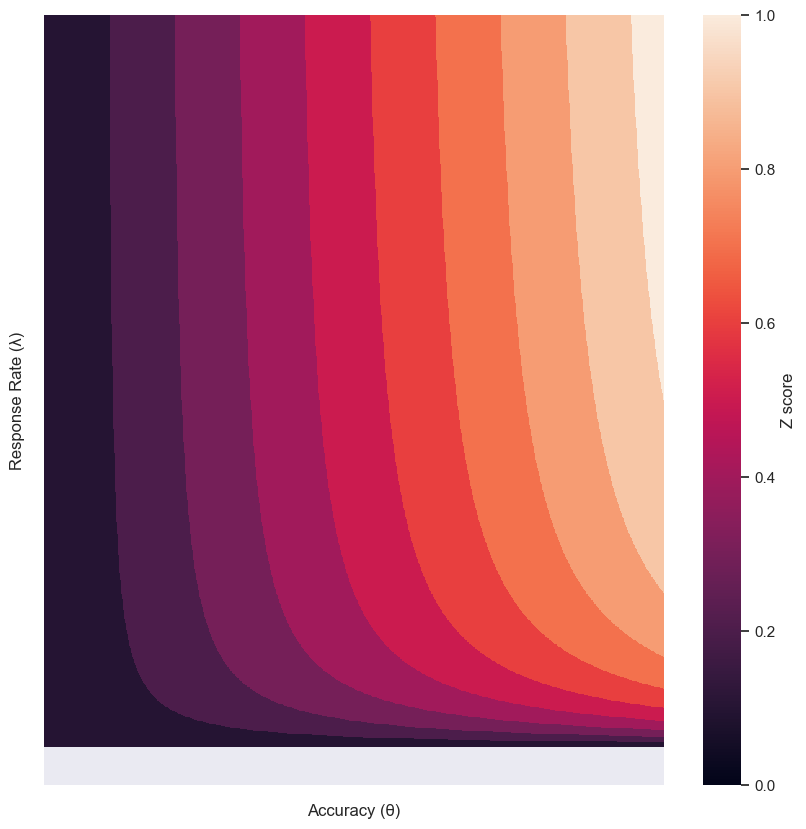

In [23]:
# Alternative way to remove the blurriness from the plot

z_array = np.linspace(0.0, 1.0, 1000) #0-1 array with 101 elements [0.  , 0.01, ...., 0.99, 1.  ])
results = np.ndarray((z_array.shape[0], z_array.shape[0])) # 101- 101 array, len(D) #101
tau =20
for i in range(0, len(z_array)):
    for j in range(0, len(z_array)):
        
        lamda = z_array[i]
        theta = z_array[j]
        _result_ = max(1 - (1/(lamda*tau)), 0)
        Z = theta*_result_
        if (0.9<Z<=1):
            results[i,j] = 1
        if (0.8<Z<=0.9):
            results[i,j] = 0.9
        if (0.7< Z <= 0.8):
            results[i,j] = 0.8
        if (0.6< Z <=0.7):
            results[i,j] = 0.7
        if (0.5< Z <=0.6):
            results[i,j] = 0.6
        if (0.4< Z<=0.5):
            results[i,j] = 0.5
        if (0.3< Z <=0.4):
            results[i,j] = 0.4
        if (0.2< Z <=0.3):
            results[i,j] = 0.3
        if (0.1< Z <=0.2):
            results[i,j] = 0.2
        if (0 < Z <=0.1):
            results[i,j] = 0.1
        if (Z == 0):
            results[i,j] = np.nan
           
fig, ax = plt.subplots()
sns.set(rc={'figure.figsize':(10,10)})
yticks = np.linspace(0,1,10)
xticks = np.linspace(0,1,10)

ax = sns.heatmap(results,cbar_kws={'label': 'Z score'}, vmin=0, vmax=1, xticklabels=np.round(xticks,1), yticklabels=np.round(yticks,1) )#xticklabels=[0.0]
ax.invert_yaxis()
ax.set_xlabel("Accuracy (θ)")
ax.set_ylabel("Response Rate (λ)")
ax.set_yticks(yticks*ax.get_ylim()[1])
ax.set_xticks(xticks*ax.get_xlim()[1])
